In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
df=pd.read_csv('Hotel Reservations.csv')

In [3]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
temp=df[df['arrival_date']==29]
temp=temp[temp['arrival_month']==2]
temp.shape

(37, 19)

In [5]:
list_to_drop= temp.index.tolist()

In [6]:
df.drop(list_to_drop,inplace=True)

In [107]:
df['date'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str))
#df['quarter']=df['date'].dt.to_period('Q')
df['quarter'] = pd.to_datetime(df['date']).dt.quarter
df_new=df[['quarter','room_type_reserved','avg_price_per_room','booking_status']]

In [108]:
df_thresh=df[['quarter','room_type_reserved','lead_time','avg_price_per_room','booking_status']]

In [144]:
rooms_to_keep = ['Room_Type 1', 'Room_Type 4']
df_thresh_count=df_thresh[df_thresh['room_type_reserved'].isin(rooms_to_keep)]

In [145]:
df_thresh_count_cancelled=df_thresh_count[df_thresh_count['booking_status']=='Canceled']

In [151]:
results = []

for room_type in df_thresh_count_cancelled['room_type_reserved'].unique():
    for quarter in df_thresh_count_cancelled['quarter'].unique():
        room_type_data = df_thresh_count_cancelled[df_thresh_count_cancelled['room_type_reserved'] == room_type]
        room_type_data = df_thresh_count_cancelled[df_thresh_count_cancelled['quarter'] == quarter]
        quartiles = room_type_data['lead_time'].quantile([0.25, 0.75])
        mean_lead_days = room_type_data['lead_time'].mean()
        ranges = [(-1, quartiles[0.25]), (quartiles[0.25], mean_lead_days),(mean_lead_days, quartiles[0.75]),
            (quartiles[0.75], room_type_data['lead_time'].max())]
        results.extend([(room_type, quarter, f'{start:.2f}-{end:.2f}',f'{start:.2f}', f'{end:.2f}',((room_type_data['lead_time'] > start) & (room_type_data['lead_time'] <= end)).sum()) for start, end in ranges])
result_df = pd.DataFrame(results, columns=['Room Type','quarter', 'Range', 'Lead_time_min','Lead_time_max','Count'])

In [152]:
result_df['Weighted_count']=result_df['Count']/df_thresh_count_cancelled.shape[0]
#result_df['Weighted_count']=result_df['Count']/result_df['Count'].sum()
result_df['Lead_time_max'] = pd.to_numeric(result_df['Lead_time_max'])
result_df['Weighted_lead_time']=result_df['Lead_time_max']/result_df['Lead_time_max'].sum()


In [153]:
result_df['Lead_time_min'] = pd.to_numeric(result_df['Lead_time_min']).astype(int)

def calculate_mean_price(row):
    room_type = row['Room Type']
    min_lead_time = row['Lead_time_min']
    max_lead_time = row['Lead_time_max']
    
    filtered_prices = df_thresh_count_cancelled[
        (df_thresh_count_cancelled['room_type_reserved'] == room_type) &
        (df_thresh_count_cancelled['lead_time'] >= min_lead_time) &
        (df_thresh_count_cancelled['lead_time'] <= max_lead_time)
    ]
    return filtered_prices['avg_price_per_room'].mean()
df_thresh_count_cancelled = df_thresh_count_cancelled.reset_index(drop=True)
# Apply the function to create the 'mean_price' column in table2
result_df['mean_price'] = result_df.apply(calculate_mean_price, axis=1)

In [154]:
result_df['total_price']=result_df['mean_price']*result_df['Count']
result_df['Weighted_price'] = result_df['total_price']/result_df['total_price'].sum()

In [155]:
a = result_df['Weighted_price'] * result_df['total_price']
b = result_df['Weighted_count'] * result_df['Count']
c = result_df['Weighted_lead_time'] * (1 / result_df['Lead_time_max'])
d = result_df['Weighted_count'] + result_df['Weighted_lead_time'] + result_df['Weighted_price']
result_df['total_revenue_calc'] = ((a+b+c)/d)
result_df['revenue_per_room_calc'] = round(((a+b+c)/d)/result_df['Count'])
result_df['%revenue'] = round((((a+b+c)/d)/result_df['Count']*100)/result_df['mean_price'])

result_df

,Room Type,quarter,Range,Lead_time_min,Lead_time_max,Count,Weighted_count,Weighted_lead_time,mean_price,total_price,Weighted_price,total_revenue_calc,revenue_per_room_calc,%revenue
0,Room_Type 1,1,-1.00-15.00,-1,15.00,267,0.023981,0.002580,105.892420,28273.276217,0.011018,8459.785692,32.0,30.0
1,Room_Type 1,1,15.00-46.57,15,46.57,379,0.034040,0.008011,107.606821,40782.985165,0.015892,11408.385260,30.0,28.0
2,Room_Type 1,1,46.57-66.00,46,66.00,149,0.013382,0.011354,97.934829,14592.289486,0.005686,2793.046931,19.0,19.0
3,Room_Type 1,1,66.00-182.00,66,182.00,264,0.023711,0.031308,100.692656,26582.861056,0.010359,4307.666309,16.0,16.0
4,Room_Type 1,2,-1.00-55.00,-1,55.00,770,0.069158,0.009461,106.003632,81622.796895,0.031807,23992.800746,31.0,29.0
5,Room_Type 1,2,55.00-126.41,55,126.41,1027,0.092240,0.021746,97.162452,99785.837747,0.038885,26001.651064,25.0,26.0
6,Room_Type 1,2,126.41-191.00,126,191.00,507,0.045536,0.032857,106.881308,54188.823106,0.021116,11731.188153,23.0,22.0
7,Room_Type 1,2,191.00-443.00,191,443.00,758,0.068080,0.076207,99.186907,75183.675465,0.029298,12986.882593,17.0,17.0
8,Room_Type 1,3,-1.00-82.00,-1,82.00,1010,0.090713,0.014106,104.260532,105303.137385,0.041035,30254.326360,30.0,29.0
9,Room_Type 1,3,82.00-157.72,82,157.72,1008,0.090534,0.027132,97.863347,98646.253672,0.038441,24876.002793,25.0,25.0


In [101]:
# Function to calculate mean price for each row in table2
def calculate_mean_price(row):
    room_type = row['room_type']
    min_lead_time = row['min_lead_time']
    max_lead_time = row['max_lead_time']
    
    filtered_prices = table1[
        (table1['room_type'] == room_type) &
        (table1['lead_time'] >= min_lead_time) &
        (table1['lead_time'] <= max_lead_time)
    ]
    return filtered_prices['price'].mean()

# Apply the function to create the 'mean_price' column in table2
table2['mean_price'] = table2.apply(calculate_mean_price, axis=1)

print(table2)


  room_type  max_lead_time  min_lead_time  mean_price
0         A             25              5  123.333333
1         A             35             15  135.000000
2         B             45             25  225.000000
3         B             55             35  250.000000
4         C             65             45  325.000000
5         C             75             55  350.000000
6         C             85             65         NaN


In [159]:
print('Possible Revenue to be Generated: $', result_df['total_revenue_calc'].sum())
print('Loss Incurred: $' ,result_df['total_price'].sum())
print("We managed to assist the hotel in recovering approximately", str(result_df['total_revenue_calc'].sum()*100
                                                                       /result_df['total_price'].sum()), '%')

Possible Revenue to be Generated: $ 682658.5065975122
Loss Incurred: $ 2566192.724709505
We managed to assist the hotel in recovering approximately 26.601996803447005 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


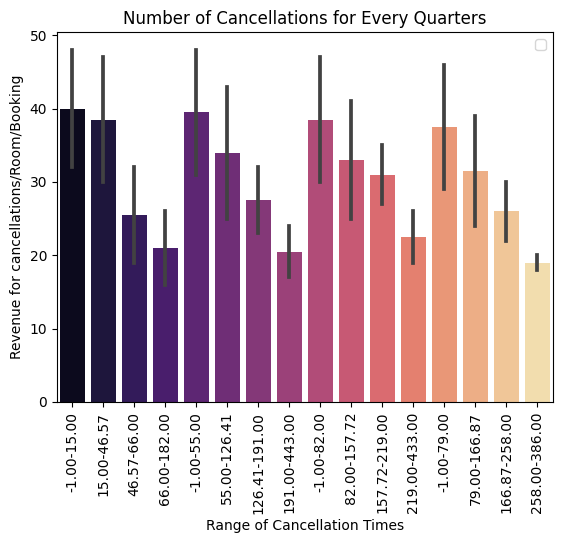

In [160]:
b=sns.barplot(x= 'Range', y='revenue_per_room_calc', data=result_df, palette='magma')
b.set_xticklabels(b.get_xticklabels(),rotation=90)
plt.xlabel('Range of Cancellation Times')
plt.ylabel('Revenue for cancellations/Room/Booking')
plt.title('Number of Cancellations for Every Quarters')
plt.legend()
plt.savefig('Cancellation Policy by Room.png',format='png')

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_22348/218712622.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_revenue_calc', data=result_df[result_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Revenue from recommendation')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_22348/218712622.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_price', data=result_df[result_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Loss')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_22348/218712622.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")


<function matplotlib.pyplot.show(close=None, block=None)>

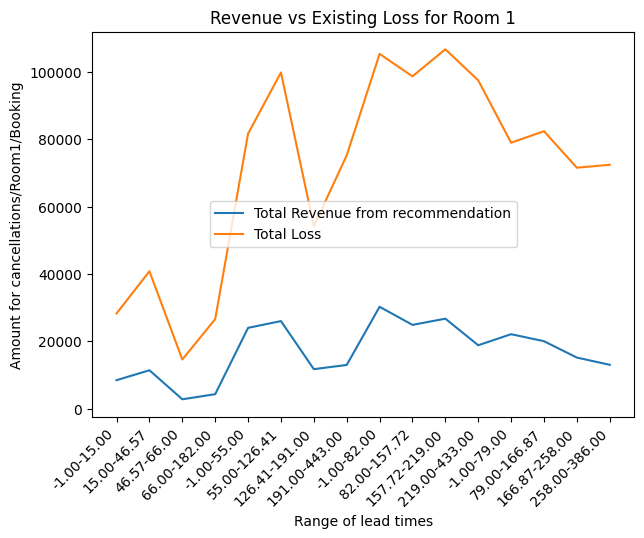

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style = "whitegrid")
a,b=plt.subplots(figsize=(7,5))

sns.lineplot(x= 'Range', y='total_revenue_calc', data=result_df[result_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Revenue from recommendation')

sns.lineplot(x= 'Range', y='total_price', data=result_df[result_df['Room Type']=='Room_Type 1'], palette='magma', label='Total Loss')

b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")
b.set_xlabel('Range of lead times')
b.set_ylabel('Amount for cancellations/Room1/Booking')
b.set_title('Revenue vs Existing Loss for Room 1')

b.legend(loc = "center")

# plt.tight_layout()
plt.savefig('Cancellation Policy by Room1.png',format='png')
plt.show

/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_22348/2994596966.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_revenue_calc', data=result_df[result_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Revenue from recommendation')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_22348/2994596966.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= 'Range', y='total_price', data=result_df[result_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Loss')
/var/folders/r9/s7zsd2g16z1gx1whz5r99cpr0000gn/T/ipykernel_22348/2994596966.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")


<function matplotlib.pyplot.show(close=None, block=None)>

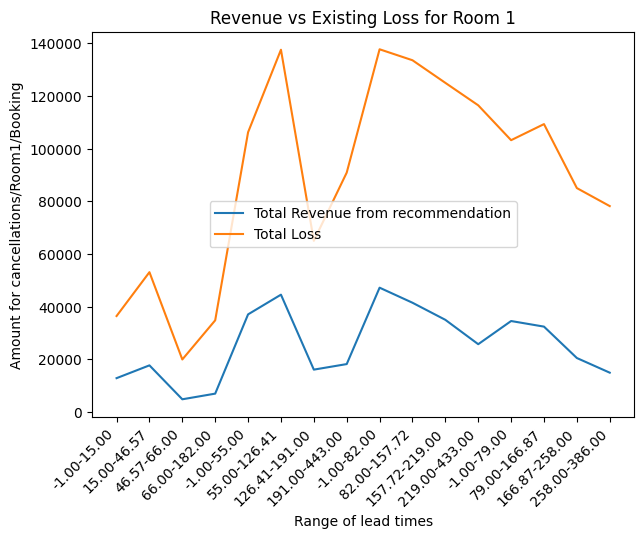

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style = "whitegrid")
a,b=plt.subplots(figsize=(7,5))

sns.lineplot(x= 'Range', y='total_revenue_calc', data=result_df[result_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Revenue from recommendation')

sns.lineplot(x= 'Range', y='total_price', data=result_df[result_df['Room Type']=='Room_Type 4'], palette='magma', label='Total Loss')

b.set_xticklabels(b.get_xticklabels(),rotation=45, ha="right")
b.set_xlabel('Range of lead times')
b.set_ylabel('Amount for cancellations/Room1/Booking')
b.set_title('Revenue vs Existing Loss for Room 1')

b.legend(loc = "center")

# plt.tight_layout()
plt.savefig('Cancellation Policy by Room1.png',format='png')
plt.show